#Long-term energy consumption predictions for commercial buildings using linear regression

Datasets from ([link](https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e))

By: Daniela Andrea Torres GómezThese datasets have hourly energy consumption and outdoor air temperature (OAT) data for commercial buildings.





In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
#Datasets
file_1 = "https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/b710e97d-29c9-4ca5-8137-63b7cf447317/download/building1retail.csv"
file_2 = "https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/4d721c37-119c-43c8-a722-a36f5eea26c8/download/building2retail.csv"
file_3 = "https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/8a91474a-a20d-4dd2-b6a1-e5412a4e6c59/download/building3retail.csv"
file_4 = "https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/c9b11976-a906-4a41-80b0-7f4b81311a13/download/building4retail.csv"
file_5 = "https://openei.org/datasets/dataset/649aa6d3-2832-4978-bc6e-fa563568398e/resource/d31fa61c-def9-4142-b58d-27f434163892/download/building5retail.csv"

In [3]:
data_1 = pd.read_csv(file_1, index_col=[0], parse_dates=True)
data_2 = pd.read_csv(file_2, index_col=[0], parse_dates=True)
data_3 = pd.read_csv(file_3, index_col=[0], parse_dates=True)
data_4 = pd.read_csv(file_4, index_col=[0], parse_dates=True)
data_5 = pd.read_csv(file_5, index_col=[0], parse_dates=True)

In [4]:
#Concatenating the datasets
df = pd.concat([data_1, data_2, data_3, data_4, data_5])

-----

#Exploring and cleaning the Dataset

In [5]:
df.head()

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8


In [6]:
#Searching for Null Values
df.isnull().sum()

OAT (F)       0
Power (kW)    0
dtype: int64

Showing the distribution of the data (standardized)

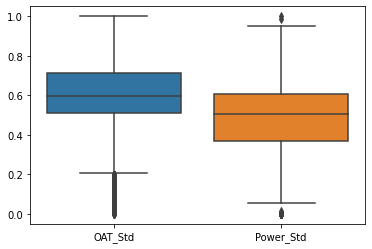

In [7]:
df_Std = pd.DataFrame()
df_Std['OAT_Std'] = (df['OAT (F)'] -df['OAT (F)'] .min())/(df['OAT (F)'].max()-df['OAT (F)'].min())
df_Std['Power_Std'] = (df['Power (kW)'] -df['Power (kW)'] .min())/(df['Power (kW)'].max()-df['Power (kW)'].min())
sns.boxplot(data=df_Std[['OAT_Std', 'Power_Std']])

###**Cleaning the dataset** 

One method is to use the **Z score**, which tells us how many standard deviations away a data point is from the mean.

In [8]:
z_scores = np.abs(stats.zscore(df[['OAT (F)', 'Power (kW)']]))
z_scores

array([[0.61709482, 1.28418119],
       [0.61709482, 1.43530262],
       [0.61709482, 1.48791527],
       ...,
       [0.42904413, 0.4938721 ],
       [0.42904413, 0.58902263],
       [0.42904413, 0.50730512]])

Choosing a threshold = 3. 

In [9]:
filtered_entries_1 = (z_scores < 3).all(axis=1) #ensures that for each row, all column satisfy the constraint.
df_clean_1 = df[filtered_entries_1]

These operation removed the outliers. This can be seen by comparing the distributions of the data sets `df` and `df_clean`.

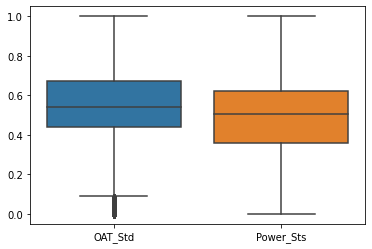

In [10]:
#Showing the distribution of the clean data (standarized )

df_Std = pd.DataFrame()
df_Std['OAT_Std'] = (df_clean_1['OAT (F)'] -df_clean_1['OAT (F)'] .min())/(df_clean_1['OAT (F)'].max()-df_clean_1['OAT (F)'].min())
df_Std['Power_Sts'] = (df_clean_1['Power (kW)'] -df_clean_1['Power (kW)'] .min())/(df_clean_1['Power (kW)'].max()-df_clean_1['Power (kW)'].min())
sns.boxplot(data=df_Std[['OAT_Std', 'Power_Sts']])


Another approach to get rid of the outliers is to use the **IQR score**. This one is used by the Box plots. The structure is:

<ol>
    <li> Upper quartile $P_{75}.$</li><br>
    <li> Lower quartile $P_{25}$</li><br>
    <li> Interquartile range $IQR=P_{75}-P_{25}$</li><br>
    <li>Upper end: It is 75% of the data plus 150% of the interquartile range. Beyond this value are the outliers. Nevertheless, if this value is greater than the largest data, simply the upper end is the largest case. 
    \begin{cases} 
   P_{\text{75}}+1.5\times IQR = UP & \text{si } UP < \text{max(Data)} \\
   \text{max(Data)}       & \text{si } UP \ge \text{max(Data)}
  \end{cases}
  <br> </li><br>
    <li>Lower end:  It is 25% of the data rest 150% of the interquartile range. Beyond this value are the outliers. Nevertheless, if this value is less than the smallest data, simply the lower end is the smallest case. 
    \begin{cases} 
   P_{\text{25}}-1.5\times IQR = LO & \text{si } LO > \text{min(Data)} \\
   \text{min(Data)}       & \text{si } LO \le \text{min(Data)}
  \end{cases}<br></li>
</ol>

So, the strategy is to use this definition of outliers to clean the dataset.

In [11]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

OAT (F)        21.000
Power (kW)    132.825
dtype: float64


In [12]:
filtered_entries = (df < (Q3 + 1.5 * IQR)) & (df > (Q1 - 1.5 * IQR))
df_clean = df[filtered_entries]
df_clean.dropna(axis=0, how='any', inplace=True)

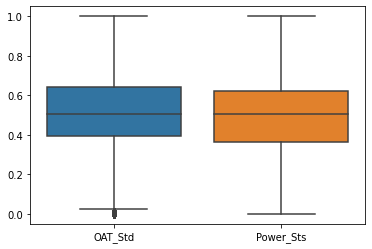

In [13]:
#Showing the distribution of the clean data (standarized )

df_Std = pd.DataFrame()
df_Std['OAT_Std'] = (df_clean['OAT (F)'] -df_clean['OAT (F)'] .min())/(df_clean['OAT (F)'].max()-df_clean['OAT (F)'].min())
df_Std['Power_Sts'] = (df_clean['Power (kW)'] -df_clean['Power (kW)'] .min())/(df_clean['Power (kW)'].max()-df_clean['Power (kW)'].min())
sns.boxplot(data=df_Std[['OAT_Std', 'Power_Sts']])

It can be seen that the last strategy erased the most data:

In [14]:
df.shape, df_clean_1.shape, df_clean.shape

((174700, 2), (172034, 2), (169914, 2))

----

#**Linear Regression**


##**Using only the data provided**

In [15]:
df_clean.head()

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51.0,165.1
2010-01-01 01:30:00,51.0,151.6
2010-01-01 01:45:00,51.0,146.9
2010-01-01 02:00:00,51.0,153.7
2010-01-01 02:15:00,51.0,153.8


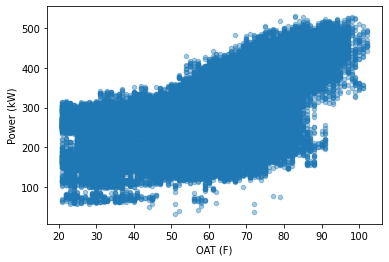

In [16]:
df_clean.plot(kind="scatter", x='OAT (F)',y='Power (kW)', alpha = 0.4)

Creating the Linear Regression model with a single characteristic.



In [17]:
X = df_clean[['OAT (F)']]    
y = df_clean['Power (kW)']   #target 

print("X:",X.shape)
print("y:",y.shape)

X: (169914, 1)
y: (169914,)


In [18]:
#Split Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=3)

#Train
linear  = LinearRegression(normalize=True)
linear.fit(X_train,y_train)

#Predictions:
y_pred = linear.predict(X_test)

#R-square error 
print("Precision with one characteristic : %.4f" %linear.score(X_test, y_test))

Precision with one characteristic : 0.3526


----
##**Using categorical variables**

Expanding the dataset

In [19]:
df_clean['hour']=df_clean.index.hour
df_clean['month']=df_clean.index.month
df_clean['day']=df_clean.index.day

df_clean.head()

,OAT (F),Power (kW),hour,month,day
Timestamp,,,,,
2010-01-01 01:15:00,51.0,165.1,1,1,1
2010-01-01 01:30:00,51.0,151.6,1,1,1
2010-01-01 01:45:00,51.0,146.9,1,1,1
2010-01-01 02:00:00,51.0,153.7,2,1,1
2010-01-01 02:15:00,51.0,153.8,2,1,1


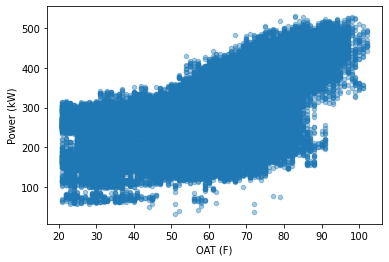

In [20]:
df_clean.plot(kind="scatter", x='OAT (F)',y='Power (kW)', alpha = 0.4)

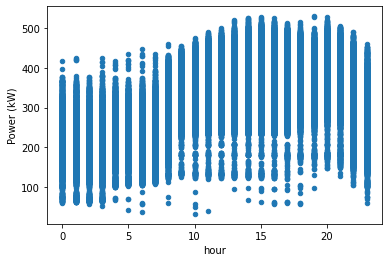

In [21]:
df_clean.plot(kind="scatter", x='hour', y='Power (kW)')

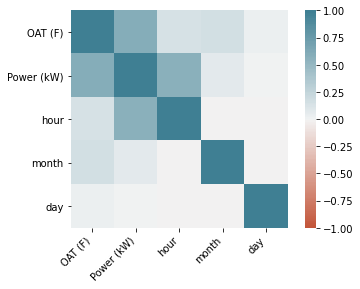

In [22]:
corr_new = df_clean.corr()

ax = sns.heatmap(
    corr_new, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The heat map shows us which pair of variables are most correlated. I will choose the 'hour' because it is the one that has the most correlation with energy consumption.

In [23]:
X = df_clean[['OAT (F)', 'hour']]
y = df_clean['Power (kW)']

#Split Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=3)

#Train
linear  = LinearRegression(normalize=True)
linear.fit(X_train,y_train)

#Prediciones:
y_pred = linear.predict(X_test)

#R-square error 
print("Precision with one characteristic : %.4f" %linear.score(X_test, y_test))

Precision with one characteristic : 0.5870


---
##**Characteristics engineering**

Now since the datasets come from 5 different buildings and the idea is to generalize the model, I know that for a specific day, there are 5 different measures. This can be seen if you choose a specific day and time:

In [24]:
df.loc['2010-04-07 00:00:00']

,OAT (F),Power (kW)
Timestamp,,
2010-04-07,52,173.7
2010-04-07,55,320.7
2010-04-07,78,253.2
2010-04-07,71,187.4
2010-04-07,69,260.0


So I'm going to group by Timestamp and apply the average to the Energy (Power Consumption) and OAT (Outside Temperature) values.

In [25]:
df_group = df_clean.groupby("Timestamp")[['Power (kW)', 'OAT (F)']].apply(np.mean)   
df_group.head()

,Power (kW),OAT (F)
Timestamp,,
2010-01-01 01:15:00,136.650,52.00
2010-01-01 01:30:00,132.200,52.00
2010-01-01 01:45:00,140.825,52.00
2010-01-01 02:00:00,141.150,52.00
2010-01-01 02:15:00,143.475,50.75


On the other hand, I am going to take the Hour and the squared value of OAT as new characteristics. Because, there seems to be a polynomial relationship between Power and OAT. Also, as this is a commercial building, I am going to consider when the staff comes to work. The opening hours are between 9:00 am and 9:00 pm. If the building is staffed, the categorical value is 1 and 0 if it is empty.

In [26]:
df_group['hour'] = df_group.index.hour
df_group['OAT**2'] = df_group['OAT (F)'] * df_group['OAT (F)']
df_group['open_hour'] = np.where((df_group.index.hour >= 9)&(df_group.index.hour <= 21), 1,0)
df_group.head()

,Power (kW),OAT (F),hour,OAT**2,open_hour
Timestamp,,,,,
2010-01-01 01:15:00,136.650,52.00,1,2704.0000,0
2010-01-01 01:30:00,132.200,52.00,1,2704.0000,0
2010-01-01 01:45:00,140.825,52.00,1,2704.0000,0
2010-01-01 02:00:00,141.150,52.00,2,2704.0000,0
2010-01-01 02:15:00,143.475,50.75,2,2575.5625,0


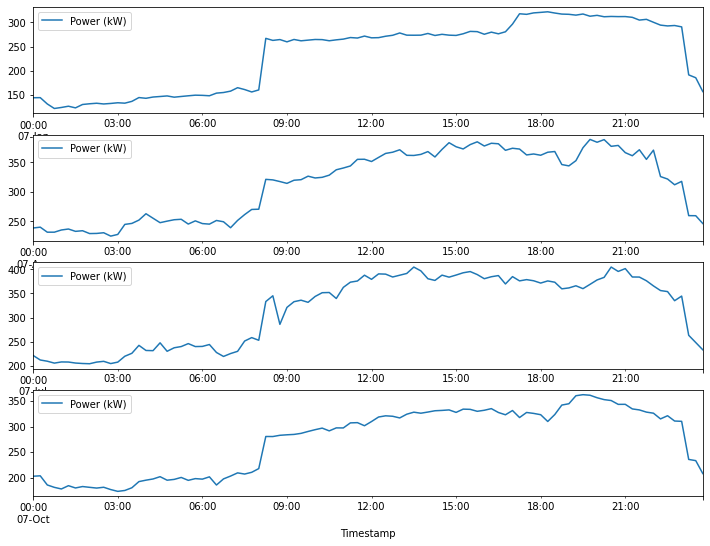

In [27]:
#Hour vs. Power:
#Same day of different months 
fig, axs = plt.subplots(4, figsize=(12, 9))
df_group.loc['2010-01-07', ['Power (kW)']].plot(ax=axs[0])
df_group.loc['2010-04-07', ['Power (kW)']].plot(ax=axs[1])
df_group.loc['2010-07-07', ['Power (kW)']].plot(ax=axs[2])
df_group.loc['2010-10-07', ['Power (kW)']].plot(ax=axs[3])

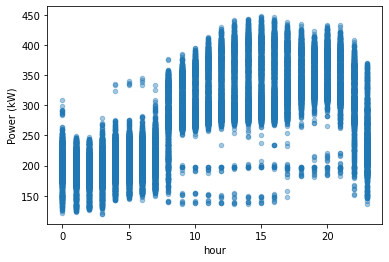

In [28]:
df_group.plot(kind="scatter", x='hour',y='Power (kW)', alpha = 0.4)

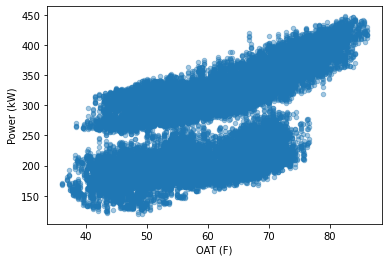

In [29]:
df_group.plot(kind="scatter", x='OAT (F)',y='Power (kW)', alpha = 0.4)

In the graph above, you can see 2 different groups of data.

In [30]:
X = df_group[['OAT (F)','OAT**2','hour', 'open_hour']]
y = df_group['Power (kW)']

X.shape, y.shape

#Split Train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=3)

#Train
linear  = LinearRegression(normalize=True)
linear.fit(X_train,y_train)

#Prediciones:
y_pred = linear.predict(X_test)

print('R2 =',linear.score(X_test,y_test)) 

R2 = 0.8462129798249303


In the following graph, we can see in 'Power vs. OAT' that the 2 groups of data come from the different times of the day (with and without staff in the building), and how this affects Energy consumption. For the same outside temperature, consumption is higher when staff are there, which is a logical conclusion.

The new and better value of R2 = 0.84 indicates that this model is improved, compared to the previus R2 = 0.3526 and R2 = 0.587.

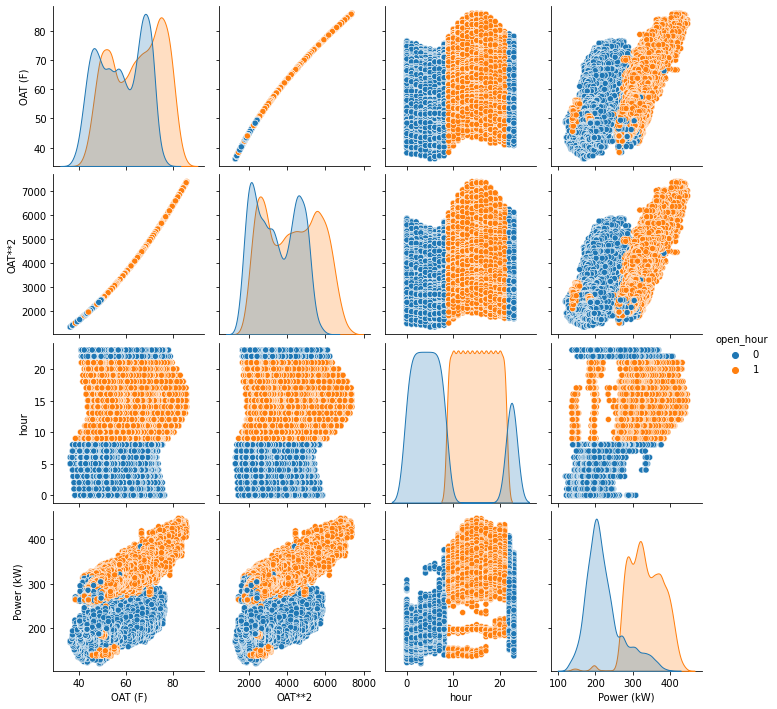

In [31]:
sns.pairplot(df_group, hue = "open_hour", vars = ['OAT (F)','OAT**2','hour','Power (kW)'])

Display of 'OAT vs. Power' and 'opening hour' as 3rd axis. Two different clusters can be appreciated.

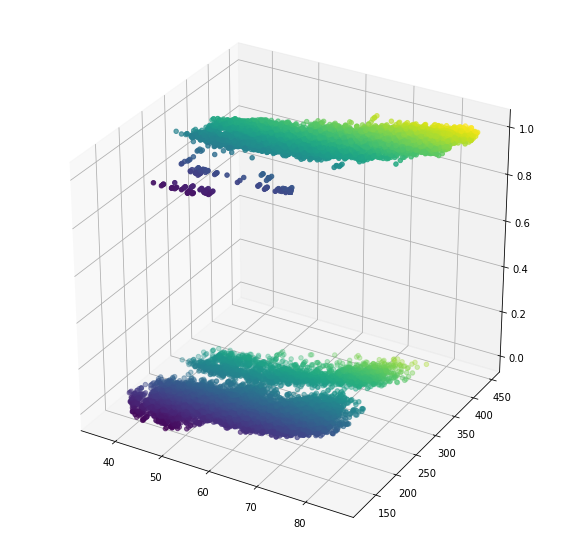

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( X_train['OAT (F)'], y_train, X_train['open_hour'], c=y_train, cmap='viridis')